In [1]:
from torchvision.datasets import MNIST

download_root = './MNIST_DATASET'
train_dataset = MNIST(download_root, train=True, download=True)


In [16]:
import torch
import numpy as np
import cv2
import wandb
import time

from denoising_diffusion_pytorch import Unet, GaussianDiffusion

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
wandb.init(project='DiffusionMNIST_test1',entity='jongminkim')
wandb.run.name = time.strftime('%Y%m%d_%H%M%S',time.localtime(time.time()))

model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8)
).to(device)
model.train()
wandb.watch(model)

diffusion = GaussianDiffusion(
    model,
    image_size = 128,
    timesteps = 1000,   # number of steps
    loss_type = 'l1'    # L1 or L2
).to(device)


# training_images = torch.rand(8, 3, 128, 128) # images are normalized from 0 to 1
MNIST_images = train_dataset.data.unsqueeze(1).repeat(1,3,1,1).numpy()
training_images = torch.zeros(60000,3,128,128)
# print(MNIST_images.shape)
for i in range(60000):
    newsize = (128,128)
    img = cv2.resize(MNIST_images[i].transpose(1,2,0),newsize)
    training_images[i] = torch.Tensor(img.transpose(2,0,1))/255.0
# print(training_images.shape)
training_images = training_images.to(device)
# loss = diffusion(training_images)
# loss.backward()
# after a lot of training

# sampled_images = diffusion.sample(batch_size = 8)
# sampled_images.shape # (4, 3, 128, 128)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jongminkim. Use `wandb login --relogin` to force relogin


In [5]:
starttime = time.time()
BATCH=64
optim = torch.optim.Adam(diffusion.denoise_fn.parameters(), lr=3e-4)
for i in range(50000):
    i += 1
    # idx = torch.randint(0,8,(BATCH,), device=device)
    # idx = [0,1,2,3,4,5,6,7]
    # trnimg = training_images[idx]
    # loss = diffusion(trnimg)
    optim.zero_grad()
    loss = diffusion(training_images)
    loss.backward()
    optim.step()
    if i % 100 == 0:
        wandb.loss({"loss": loss})
    if i % 1000 == 0:
        print(str(i)+"th step : "+str(loss.item())+", time : "+str(time.time()-starttime))
    if i % 10000 == 0:
        torch.save(model.state_dict(), "weights/weights_MNIST_"+str(i//1000)+"k.pt")
print("Total Elapsed Time : "+str(time.time()-starttime))

100th step : 0.027105389162898064
200th step : 0.01625964418053627
300th step : 0.020681075751781464
400th step : 0.021980255842208862
500th step : 0.019046515226364136
600th step : 0.03515280783176422
700th step : 0.017744798213243484
800th step : 0.023208413273096085
900th step : 0.02703198790550232
1000th step : 0.018839199095964432
Total Elapsed Time : 126.61256241798401


In [13]:
sampled_images = diffusion.sample(batch_size = 8)
print(sampled_images.shape)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([8, 3, 128, 128])


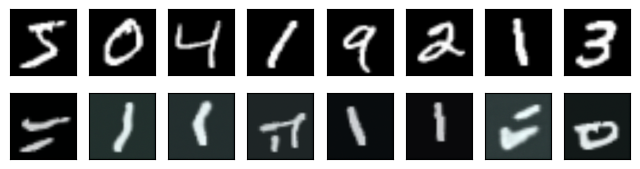

In [15]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

fig = plt.figure(figsize = (8,2))
for i in range(8):
    ax = fig.add_subplot(2,8,i+1)
    img = (training_images[i,:].to('cpu').squeeze(0).permute(1,2,0)).numpy()
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_xticks([]), ax.set_yticks([])

for i in range(8):
    ax = fig.add_subplot(2,8,i+9)
    img = (sampled_images[i,:].to('cpu').squeeze(0).permute(1,2,0)).numpy()
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_xticks([]), ax.set_yticks([])

#plt.show()